# Entangled States

In this notebook we explore the subset of methods in `entangled_states.py` that are related specifically to [graph states](https://en.wikipedia.org/wiki/Graph_state). Although it is worth noting that the module also alows one to create [GHZ](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) states.


Graph states are a very simple entangled state construct as there are only two steps:

1. prepare all qubits on the desired lattice in the $|+\rangle$ state 
2. Do a CZ gate between all the edges on the lattice that have two qubit gates

There is a very simple way to benchmark short depth circuits on [NISQ](https://arxiv.org/abs/1801.00862) hardware. First choose a random connected subgraph on $N$ qubits, compute the fidelity of the graph state to the ideal and repeat $K$ times. Do this for increasingly large graphs. Then plot the mean fidelity as a function of the number of qubits.

**Note:** in some of the cells below there is a comment `# NBVAL_SKIP` this is used in testing to speed up our tests by skipping that particular cell.

## Setup

In [1]:
import os
from typing import List

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer

from forest.benchmarking.compilation import basic_compile
from forest.benchmarking.entangled_states import create_graph_state, measure_graph_state

## Parity measurements of graph states



### graph state measurement and plotting functions

Here, we make programs on a graph with qubits as nodes on a quantum device. 

In [2]:
def run_graph_state(qc: QuantumComputer,
                    nodes: List[int],
                    graph: nx.classes.graph.Graph,
                    n_shots: int = 1000):
    assert all([node in qc.qubits() for node in nodes]), "One or more nodes provided does not fall in the graph"
    
    results = []
    
    for node in nodes:
        print(f"Running graph state on QC{node}")
        program = create_graph_state(graph)
        measure_prog, c_addrs = measure_graph_state(graph, focal_node=node)
        program += measure_prog
        program = basic_compile(program)
        program.wrap_in_numshots_loop(n_shots)
        executable = qc.compile(program)

        for theta in np.linspace(-np.pi, np.pi, 21):
            memory_map = { "theta": [theta] }
            bitstrings = qc.qam.run(executable, memory_map).get_register_map().get('ro')
            parities = np.sum(bitstrings, axis=1) % 2
            avg_parity = np.mean(parities)
            results.append({
                'focal_node': node,
                'theta': theta,
                'n_bitstrings': len(bitstrings),
                'avg_parity': float(avg_parity),
            })

    pd.DataFrame(results).to_json('graph-state.json')

In [3]:
def plot_graph_state_parity():
    from matplotlib import pyplot as plt
    df = pd.read_json('graph-state.json')
    for focal_node in df['focal_node'].unique():
        df2 = df[df['focal_node'] == focal_node].sort_values('theta')
        plt.plot(df2['theta'], df2['avg_parity'], 'o-', label=f'{focal_node}')

    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.ylabel('parity')
    plt.ylim([0,1])
    plt.tight_layout()
    plt.show()

### creating a graph on a Rigetti lattice and running graph state measurements on it

We start with some connected qubits. For a simple example, we'll take three qubits arranged in a line, forming a three-vertex path, which we can represent in avant-garde ASCII art as follows:

    1 - 2 - 3
    
We define a graph with our qubits as nodes and pairs of coupled qubits as edges, so we have `[1, 2, 3]` as our nodes and `[(1, 2), (2, 3)]` as our edges. `networkx` has handy utilities for defining graphs from sets of edges and visualizing them so that we don't have to rely on my lackluster ASCII art. 

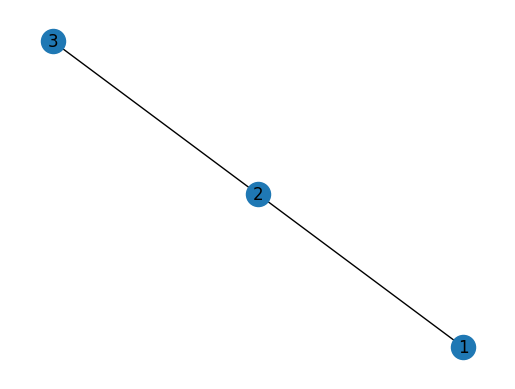

In [4]:
# define the graph by its nodes and edges
nodes = [1, 2, 3]
graph = nx.from_edgelist([(1, 2), (2, 3)])

# make a figure representing the graph
nx.draw_networkx(graph)

# hide axis labels and figure outline
_ = plt.axis("off")

Now we can run the graph state measurement on each of the qubits in the simple, linear lattice we've specified. 

Noiseless


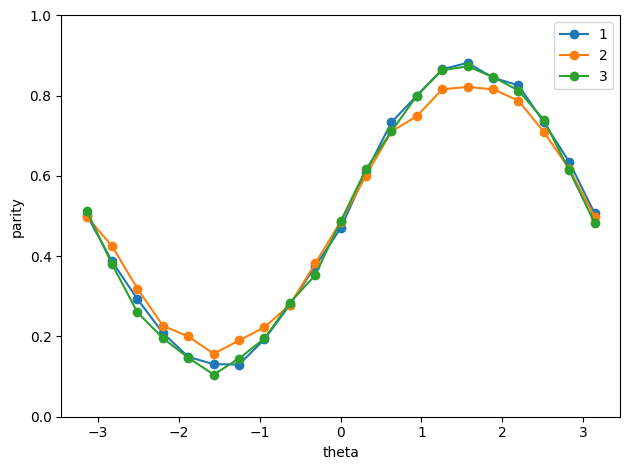

In [5]:
nodes = [1, 2, 3]
graph = nx.from_edgelist([(1, 2), (2, 3)])

qc = get_qc('9q-square-qvm')

if not os.path.exists('graph-state.json'):
    run_graph_state(qc, nodes, graph)
    
print('Noiseless')
plot_graph_state_parity()

Running graph state on QC1
Running graph state on QC2
Running graph state on QC3
Noisy


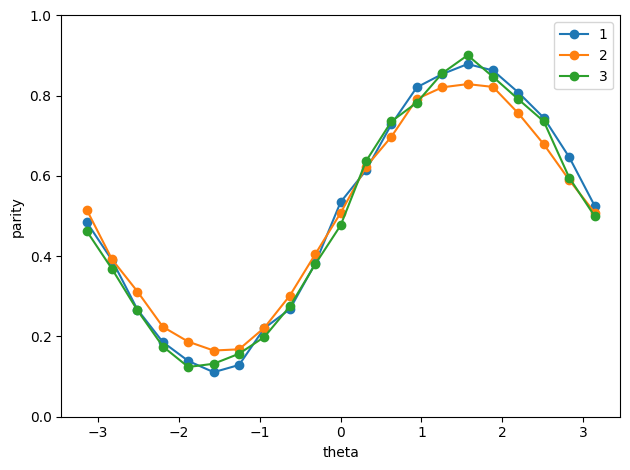

In [6]:
# NBVAL_SKIP

qc_noisy = get_qc('9q-square-qvm',noisy=True)


run_graph_state(qc_noisy, nodes, graph)

print('Noisy')
plot_graph_state_parity()

## Tomography of the graph state

An old school way of determining the quality of quantum hardware is to produce a state and then do tomography on state and compare it to the ideal state. So lets do that on our graph state, using the tomography tools in forest benchmarking.

In [7]:
from forest.benchmarking.tomography import generate_state_tomography_experiment, linear_inv_state_estimate
from forest.benchmarking.observable_estimation import estimate_observables
from forest.benchmarking.operator_tools.project_state_matrix import project_state_matrix_to_physical

In [8]:
prep_prog = create_graph_state(graph)
qubits = list(prep_prog.get_qubit_indices())
num_shots = 4000

In [9]:
# set up the experiment
experiment = generate_state_tomography_experiment(program=prep_prog, qubits=qubits)

# get noiseless results
results = list(estimate_observables(qc, experiment, num_shots=num_shots))

# simple estimator
rho = linear_inv_state_estimate(results, qubits=qubits)
rho_est = project_state_matrix_to_physical(rho)

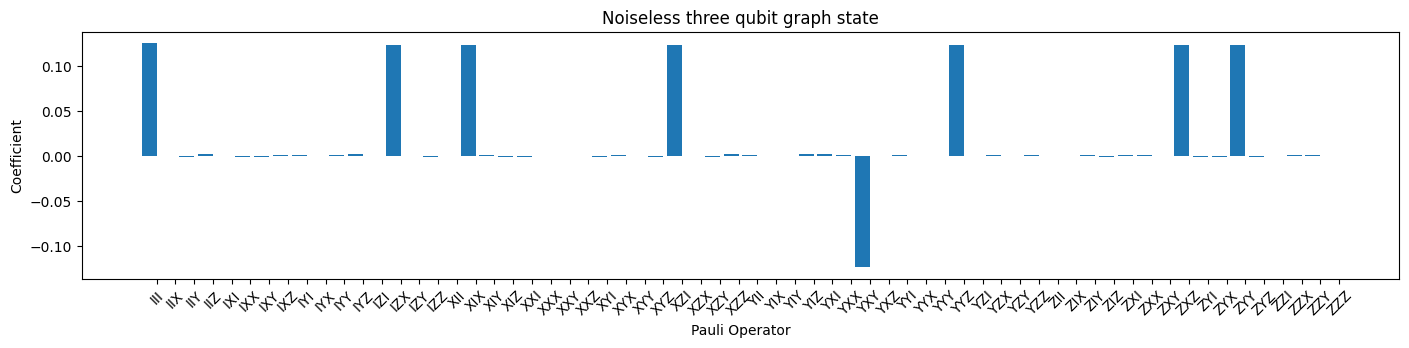

In [10]:
from forest.benchmarking.operator_tools.superoperator_transformations import vec, computational2pauli_basis_matrix 
from forest.benchmarking.utils import n_qubit_pauli_basis
from forest.benchmarking.plotting.state_process import plot_pauli_bar_rep_of_state

# vec(rho) then convert it to the pauli rep
n_qubits = 3
pl_basis = n_qubit_pauli_basis(n_qubits)
c2p = computational2pauli_basis_matrix(2**n_qubits)
rho_pauli = np.real(c2p @ vec(rho_est)) 

# plot
f, (ax1) = plt.subplots(1, 1, figsize=(17, 3.2))
plot_pauli_bar_rep_of_state(rho_pauli.flatten(), ax1, pl_basis.labels, 'Noiseless three qubit graph state')

In [11]:
# NBVAL_SKIP
# get noisy results
results_noisy = list(estimate_observables(qc_noisy, experiment, num_shots=num_shots))

# simple estimator
rho_noisy = linear_inv_state_estimate(results_noisy, qubits=qubits)
rho_noisy_est = project_state_matrix_to_physical(rho_noisy)

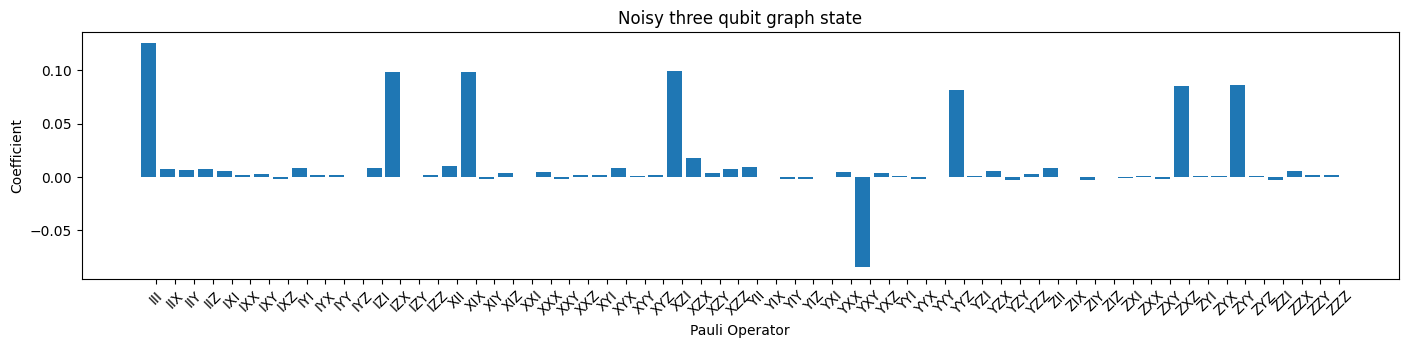

In [12]:
# NBVAL_SKIP
rho_pauli_noisy = np.real(c2p @ vec(rho_noisy_est)) 

f, (ax2) = plt.subplots(1, 1, figsize=(17, 3.2))
plot_pauli_bar_rep_of_state(rho_pauli_noisy.flatten(), ax2, pl_basis.labels, 'Noisy three qubit graph state')

In [13]:
# NBVAL_SKIP
from forest.benchmarking.distance_measures import fidelity, trace_distance

print('The fidelity between the noiseless and noisy states is', np.round(np.real(fidelity(rho,rho_noisy)),3),'\n')

print('The Trace distance between the noiseless and noisy states is', np.round(np.real(trace_distance(rho,rho_noisy)),3))

The fidelity between the noiseless and noisy states is 0.876 

The Trace distance between the noiseless and noisy states is 0.159


## Direct Fidelity estimation of the graph state

Two common problems with state tomography are

1. the ways of visualizing the state are not helpful for large numbers of qubits
2. most of the time you care about the fidelity of the state to a target state.

Here we use the direct fidelity estimation method in forest benchmarking to directly measure the fidelity of the graph state.


In [14]:
from pyquil.api import BenchmarkConnection
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             acquire_dfe_data,
                                                             estimate_dfe )

In [15]:
bm = BenchmarkConnection()

In [16]:
# state dfe on a perfect quantum computer
state_exp = generate_exhaustive_state_dfe_experiment(bm, prep_prog, qubits)

results = acquire_dfe_data(qc, state_exp, num_shots=num_shots)

fid_est, fid_std_err = estimate_dfe(results, 'state')

print('The estimated fidelity is ', fid_est)

The estimated fidelity is  1.0


In [17]:
# NBVAL_SKIP

# state dfe on a noisy quantum computer
results_noisy = acquire_dfe_data(qc_noisy, state_exp, num_shots=num_shots)

fid_est_noisy, fid_std_err_noisy = estimate_dfe(results_noisy, 'state')

print('The estimated fidelity is ', fid_est_noisy)

The estimated fidelity is  0.9706517981738176
